In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [44]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Data Exploring
* * * *

# Preprocessiong
* * * *

In [45]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

# Modeling
* * * * *

**Import librairies**

In [47]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

**Define a cross validation strategy**

In [48]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=2017).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, train_target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base models

### Preparation

-  **LASSO  Regression**  : 

The sklearn's  **Robustscaler()**  method on pipeline is used since LASSO is easily affected by outliers.

>[RobustScaler](https://blog.nownabe.com/2017/11/19/1185.html)
>平均値と分散のかわりに中央地と四分位数を用いる
>外れ値を無視する

In [49]:
# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

LAS = make_pipeline(RobustScaler(), Lasso(alpha =1e-05, random_state=1))

- **Elastic Net Regression** :

As well as Lasso, we made this robust to outliers.

In [50]:
#ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

ENE = make_pipeline(RobustScaler(), ElasticNet(alpha=0.064, l1_ratio=.9, random_state=2017))

- **Kernel Ridge Regression** :

In [51]:
#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

KRR = KernelRidge(alpha=0.1, coef0=20, degree=2, gamma=100.0, kernel='polynomial',kernel_params=None)

- **XGBoost** :

In [52]:
#XGR = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                             learning_rate=0.05, max_depth=3, 
#                             min_child_weight=1.7817, n_estimators=2200,
#                             reg_alpha=0.4640, reg_lambda=0.8571,
#                            subsample=0.5213, silent=1,
#                             seed =0, nthread = -1)

XGR = xgb.XGBRegressor(colsample_bytree= 1.0, learning_rate= 0.1, max_depth=2, min_child_weight= 14, n_estimators= 100, objective= 'reg:gamma', subsample= 0.8)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers

In [53]:
#GBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                   max_depth=4, max_features='sqrt',
#                                   min_samples_leaf=15, min_samples_split=10, 
#                                   loss='huber', random_state =5)

GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                max_depth=4, max_features=0.1,
                                min_samples_leaf=17, min_samples_split=10, 
                                loss='huber', random_state =2017)

- **LightGBM** :

In [54]:
#LGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                              learning_rate=0.05, n_estimators=720,
#                              max_bin = 55, bagging_fraction = 0.8,
#                              bagging_freq = 5, feature_fraction = 0.2319,
#                              feature_fraction_seed=9, bagging_seed=9,
#                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


LGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                        learning_rate=0.05, n_estimators=100,
                        reg_alpha= 1.2, reg_lambda= 1.4, 
                        subsample= 0.75)

### Base models scores

In [55]:
score = rmsle_cv(LAS)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENE)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBR)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(XGR)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(LGB)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 6.4988 (0.3139)

ElasticNet score: 6.5024 (0.3112)

Kernel Ridge score: 6.1857 (0.3479)

Gradient Boosting score: 6.2250 (0.3464)

Xgboost score: 6.1819 (0.3542)

LGBM score: 6.1850 (0.3577)



## Stacking  models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

### 1. Averaged base model
**Averaged base models class**

In [56]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 



In [57]:
#averaged_models = AveragingModels(models = (ENE, GBR, KRR, LAS))
averaged_models = AveragingModels(models = (KRR, GBR, XGR))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 6.1693 (0.3511)



### 2. Less simple Stacking : Adding a Meta-model

**Stacking averaged Models Class**

In [58]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [59]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENE, GBR, KRR),
                                                 meta_model = LAS)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 6.1755 (0.3456)


### 3. Ensembling StackedRegressor, XGBoost and LightGBM

In [60]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

**StackedRegressor:**

In [61]:
stacked_averaged_models.fit(train.values, train_target)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmsle(train_target, stacked_train_pred))

6.09256738344


**XGBoost:**

In [62]:
XGR.fit(train, train_target)
xgb_train_pred = XGR.predict(train)
xgb_pred = XGR.predict(test)
print(rmsle(train_target, xgb_train_pred))

6.09006203477


**LightGBM:**

In [63]:
LGB.fit(train, train_target)
lgb_train_pred = LGB.predict(train)
lgb_pred = LGB.predict(test.values)
print(rmsle(train_target, lgb_train_pred))

6.06337519612


### Calculate score

In [32]:
a = 0
b = 0
c = 0

scores = []


In [35]:
for a_i in range(a,100,1):
    if 100 > a_i:
        for b_i in range(b,100,1):
            if 100 - a_i > b_i:
                c_i = 100 - a_i - b_i
                
                scores.append([a_i,b_i,c_i])        

In [39]:
best_score = 10
scores = []
weight_s = 0.0
weight_x = 0.0
weight_l = 0.0

for ws in np.arange(weight_s,1.01,0.01):
    if 100 > ws:
        for wx in np.arange(weight_x,1.01,0.01):
            if 100 - ws > wx:
                wl = 1 - ws - wx
        
                rmsle_tmp = rmsle(train_target,stacked_train_pred*ws + xgb_train_pred*wx + lgb_train_pred*wl )
                scores.append(rmsle_tmp)

                if best_score > rmsle_tmp:
                    best_score = rmsle_tmp
                    weight_s = ws
                    weight_x = wx
                    weight_l = wl

print("best_score %f" % best_score)
print("weight_s %f" % weight_s)
print("weight_x %f" % weight_x)
print("weight_l %f" % weight_l)

best_score 6.062367
weight_s 0.150000
weight_x 0.000000
weight_l 0.850000


In [28]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(train_target,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
6.0784396635


In [29]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(train_target,stacked_train_pred*0.15 +
               xgb_train_pred*0.01 + lgb_train_pred*0.84 ))

RMSLE score on train data:
6.0624836888


In [40]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(train_target,stacked_train_pred*0.15 +
               xgb_train_pred*0.00 + lgb_train_pred*0.85 ))

RMSLE score on train data:
6.06236654826


In [68]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(train_target,stacked_train_pred*0.15 +
               xgb_train_pred*0.10 + lgb_train_pred*0.75 ))

RMSLE score on train data:
6.06369702241


**Ensemble prediction:**

In [25]:
ensemble = stacked_pred*0.15 + xgb_pred*0.01 + lgb_pred*0.84

In [41]:
ensemble = stacked_pred*0.15 + xgb_pred*0.00 + lgb_pred*0.85

In [71]:
ensemble = stacked_pred*0.15 + xgb_pred*0.07 + lgb_pred*0.78

# Submission

In [72]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = ensemble
sub.to_csv('rs_hourly_submission_02Jan18_03.csv',index=False)

# GridSearch

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=2017).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, train_target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Gradient Boosting Regression

Reference
- [Gradient Boosted Regression Trees](https://www.datarobot.com/blog/gradient-boosted-regression-trees/)
- [Caifornia house price predictions with Gradient Boosted Regression Trees](https://shankarmsy.github.io/stories/gbrt-sklearn.html)

In [11]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) Create model
# Set params
# Scores XXX
est = GradientBoostingRegressor(n_estimators=3000)

# 2) Set the grid
param_grid = {'n_estimators':[100,1000,3000], 
              'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [3, 5, 9, 17],
#              'min_saples_split': [5, 10, 15],
              'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }
# 3) Run GridSearch
grid = GridSearchCV(est, param_grid, n_jobs=5).fit(X_train, y_train)

# 4) Show best Params and Score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)
print("MSE: ", grid.best_score_)

# 5) Learning with best params
gbm_g = GradientBoostingRegressor(**grid.best_params_)
gbm_g.fit(X_train, y_train)
y_pred_gs = gbm_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

______________________________
Result of Gridsearch
Best params:  {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 0.1, 'min_samples_leaf': 17, 'n_estimators': 100}
Best Estimator:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=17,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
MSE:  0.336578545079
______________________________
vs Prediction
RMSE from local train:  6.00336616982
MSE from local train:  36.040405369
R2 from local train:  0.39952132305


### LGBM

In [ ]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) Create model
mdl = lgb.LGBMRegressor(boosting_type= 'gbdt', 
                        n_jobs = 5,
                        metric='RMSE'
                       )


#Best params:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 
#'max_depth': 3, 'n_estimators': 100, 'num_leaves': 5, 
#'objective': 'regression', 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'subsample': 0.75}

# 2) Set params for gridsearch
gridParams = {
    'objective': ['binary','regression'],
    'num_leaves': [4,5,6], #2,10,20,100   
    'learning_rate': [0.05, 0.06], # 0.005,
    'n_estimators': [100], #8,24,
    'colsample_bytree' :[0.8, 0.85, 0.9], #0.64,
    'reg_lambda' : [1.3,1.4,1.5], #1,1.2,
    'max_depth' :[2,3,4], #1,2,5,10
    'subsample' :[0.7,0.75], 
    'reg_alpha' : [1.2], #0.1,0.51,
#    'min_split_gain' :[],
#    'subsample_for_bin' :[],
#    'max_drop' :[], 
#    'gaussian_eta' :[], 
#    'drop_rate' :[],
#    'silent' :[], 
#    'boosting_type' :['gbdt'], 
#    'min_child_weight' :[], 
#    'skip_drop' :[], 
#    'fair_c' :[], 
#    'seed' :[], 
#    'poisson_max_delta_step' :[], 
#    'subsample_freq' :[], 
#    'max_bin' :[],  #55
#    'nthread' :[], 
#    'min_child_samples' :[], 
#    'huber_delta' :[], 
#    'use_missing' :[], 
#    'uniform_drop' :[], 
#    'bagging_fraction': [] #0.8,
#    'bagging_freq': [] # 5
#    'feature_fraction': [] # 0.2319,
#    'feature_fraction_seed': [] #9
#    'bagging_seed': [] #9,
#    'min_data_in_leaf': [] #6
#    'min_sum_hessian_in_leaf': [] # 11                              
#    'xgboost_dart_mode' :[]
}

# 3) Run GridSearch
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# 4) Show best Params and Score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)
print("MSE: ", grid.best_score_)

# 5) Learning with best params
lgm_g = lgb.LGBMRegressor(**grid.best_params_)
lgm_g.fit(X_train, y_train)
y_pred_gs = lgm_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


__ Score: __
```
______________________________
Result of Gridsearch
Best params:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 5, 'objective': 'regression', 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'subsample': 0.75}
Best Estimator:  LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.05,
       max_bin=255, max_depth=3, metric='RMSE', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=5, num_leaves=5, objective='regression', random_state=None,
       reg_alpha=1.2, reg_lambda=1.4, silent=True, subsample=0.75,
       subsample_for_bin=200000, subsample_freq=1)
MSE:  0.349386487223
______________________________
vs Prediction
RMSE from local train:  6.02327567741
MSE from local train:  36.2798498861
R2 from local train:  0.395531874947
```

### Kernel Ridge

In [ ]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) Create model
model = KernelRidge()

# 2) Set params for gridsearch
param_grid = {
    "alpha": [1e0, 0.1, 1e-2, 1e-3],
    "gamma": np.logspace(-2, 2, 5),
    "kernel" : ['polynomial','rbf'],
    "degree" : [2,5,10,20], 
    "coef0" : [2.5,5,10,20],
}

# 3) Run GridSearch
model_ = GridSearchCV(estimator= model, param_grid= param_grid, scoring='neg_mean_squared_error',cv=5, n_jobs=-1)
model_.fit(X_train, y_train)

# 4) Show best Params and Score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", model_.best_params_)
print("Best Estimator: ", model_.best_estimator_)
print("MSE: ", model_.best_score_)

# 5) Learning with best params
krr_g = KernelRidge(**model_.best_params_)
krr_g.fit(X_train, y_train)
y_pred_gs = krr_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

______________________________
Result of Gridsearch
Best params:  {'alpha': 0.1, 'coef0': 20, 'degree': 2, 'gamma': 100.0, 'kernel': 'polynomial'}
Best Estimator:  KernelRidge(alpha=0.1, coef0=20, degree=2, gamma=100.0, kernel='polynomial',
      kernel_params=None)
MSE:  -38.9194812638
______________________________
vs Prediction
RMSE from local train:  5.9962579498
MSE from local train:  35.9551094006
R2 from local train:  0.400942461623


In [ ]:
#array([  1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
#         1.00000000e+01,   1.00000000e+02])

### Lasso

Referring to followings
- [Exploring features and regression models](https://www.kaggle.com/youssefer/xgb-and-lasso-regression)
- [House Prices # Regression and Bagging techniques](https://www.kaggle.com/aarti1/house-prices-regression-and-bagging-techniques)
- [XGB and Lasso Regression](https://www.kaggle.com/youssefer/xgb-and-lasso-regression)

10	Lasso regression


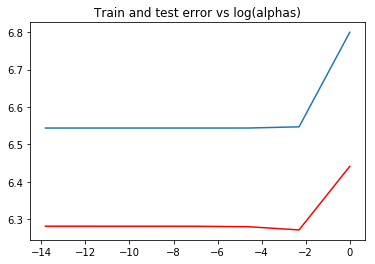

In [22]:
#------------------------------------------------------------
print ("10	Lasso regression")
# importance of train set size: first, we set a relevant alpha

rm_tr=[]
rm_te=[]

opti=[]
alphas=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
# alphas=np.linspace(1e-4,1e-2,20)
#X_train, X_test, y_train, y_test = train_test_split(
#     feat, price, test_size=0.8, random_state=42)

for al in alphas:
	ls=Lasso(alpha=al, copy_X=True, fit_intercept=True, max_iter=5000,
	   normalize=False, positive=False, precompute=False, random_state=111,
	   selection='cyclic', tol=0.0001, warm_start=False)
	ls.fit(X_train,y_train)
	rm_tr.append(np.sqrt(mean_squared_error(y_train,ls.predict(X_train))))
	rm_te.append(np.sqrt(mean_squared_error(y_test,ls.predict(X_test))))

plt.figure()
plt.cla()
plt.clf()
plt.plot(np.log(alphas),rm_tr,np.log(alphas),rm_te,"r")	
plt.title("Train and test error vs log(alphas)")
#plt.savefig('fig4.png')

In [44]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) Create model
model = Lasso()

# 2) Set params for gridsearch
param_grid = { 'alpha': [i/100000 for i in range(1,50000)]}

# 3) Run GridSearch
model_ = GridSearchCV(estimator= model, param_grid= param_grid, scoring='neg_mean_squared_error',cv=5, n_jobs=-1)
model_.fit(X_train, y_train)

# 4) Show best Params and Score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", model_.best_params_)
print("Best Estimator: ", model_.best_estimator_)
print("MSE: ", model_.best_score_)

# 5) Learning with best params
las_g = xgb.XGBRegressor(**model_.best_params_)
las_g.fit(X_train, y_train)
y_pred_gs = las_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

______________________________
Result of Gridsearch
Best params:  {'alpha': 1e-05}
Best Estimator:  Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
MSE:  -42.9326318668
______________________________
vs Prediction
RMSE from local train:  6.02475299555
MSE from local train:  36.2976486573
R2 from local train:  0.395235324935


Compute alpha = 1e-05 - 6.4987767707721575
Compute alpha = 1.6681005372000593e-05 - 6.498776706041236
Compute alpha = 2.782559402207126e-05 - 6.498776727807145
Compute alpha = 4.641588833612782e-05 - 6.498777125134102
Compute alpha = 7.742636826811278e-05 - 6.498778792472601
Compute alpha = 0.0001291549665014884 - 6.498784368998028
Compute alpha = 0.00021544346900318823 - 6.498801449091047
Compute alpha = 0.00035938136638046257 - 6.498851582625532
Compute alpha = 0.0005994842503189409 - 6.498995429448667
Compute alpha = 0.001 - 6.499402929830128


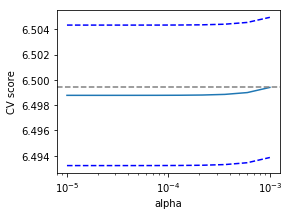

In [47]:
# =================================================
# Manual GridSearch
# =================================================
# Search `alpha` regression parameters
#x_train = x[x.train_test == 1]
lasso = Lasso(max_iter=1e2, normalize=True)
alphas = np.logspace(-5, -3, 10)
scores = []
scores_std = []
for alpha in alphas:
    lasso.alpha = alpha
    this_scores = np.sqrt(-cross_val_score(lasso, train, train_target, cv=5, scoring='mean_squared_error'))
    print('Compute alpha = {} - {}'.format(alpha, np.mean(this_scores)))
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(train)), 'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(train)), 'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
#plt.savefig('lasso_lars.png')

### Elastic Net Regression

In [15]:
from sklearn.linear_model import ElasticNetCV

In [16]:
enr_cv = ElasticNetCV(cv=5, random_state=2017)
enr_cv.fit(X_train, y_train)
print(enr_cv.alpha_)
print(enr_cv.l1_ratio_)
#print(enr_cv.intercept_) 

0.0649678226388
0.5


In [41]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) Create model
regr = ElasticNet()

# 2) Set params for gridsearch
enr_params = {
    'alpha' : [0.0640, 0.0645, 0.0649678226388, 0.65],
    'l1_ratio' : [0.4,0.5,0.6,0.7,0.8,0.9]
}

# 3) Run gridsearch
grid_enr = GridSearchCV(regr,enr_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
grid_enr.fit(X_train, y_train)

# 4) Show best params and score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", grid_enr.best_params_)
print("Best Estimator: ", grid_enr.best_estimator_)
print("MSE: ", grid_enr.best_score_)

# 5) Learning with best params
eln_g = ElasticNet(**grid_enr.best_params_)
eln_g.fit(X_train, y_train)
y_pred_gs = eln_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

______________________________
Result of Gridsearch
Best params:  {'alpha': 0.064, 'l1_ratio': 0.9}
Best Estimator:  ElasticNet(alpha=0.064, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
MSE:  -42.9581056118
______________________________
vs Prediction
RMSE from local train:  6.2730675813
MSE from local train:  39.3513768796
R2 from local train:  0.344356355515


### XGBoost

In [48]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) xgboostモデルの作成
reg = xgb.XGBRegressor()

# 2) XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.05,0.75,0.1,0.125],
    'n_estimators' : [50,100,200],
    'max_depth' : [2,4,6],
    'subsample' : [0.79,0.8,0.81,0.85],
    'colsample_bytree' : [0.9,1.0],
    'min_child_weight' : [13,14, 15, 16]
}

# 3) Run GridSearch
grid_xgb = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# 4) Show best Params and Score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", grid_xgb.best_params_)
print("Best Estimator: ", grid_xgb.best_estimator_)
print("MSE: ", grid_xgb.best_score_)

# 5) Learning with best params
xgr_g = xgb.XGBRegressor(**grid_xgb.best_params_)
xgr_g.fit(X_train, y_train)
y_pred_gs = xgr_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 14, 'n_estimators': 100, 'objective': 'reg:gamma', 'subsample': 0.8}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=14, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
MSE:  -38.7922204065
RMSE from local train:  5.99283617268
MSE from local train:  35.9140853925
R2 from local train:  0.401625973415
